Veri başarıyla yüklendi!

Pivot işlemi tamamlandı. Baseline özelliği eklendi.
                 time  use [kW]  Hourly_Baseline
0 2016-01-01 05:00:00  0.932833         0.801527
1 2016-01-01 05:00:01  0.934333         0.801527
2 2016-01-01 05:00:02  0.931817         0.801527
3 2016-01-01 05:00:03  1.022050         0.801527
4 2016-01-01 05:00:04  1.139400         0.801527

Model eğitiliyor... (Bu işlem verinin boyutuna göre biraz sürebilir)
------------------------------
Model R2 Skoru: 0.5630
Hata Payı (MAE): 0.2851 kW
------------------------------


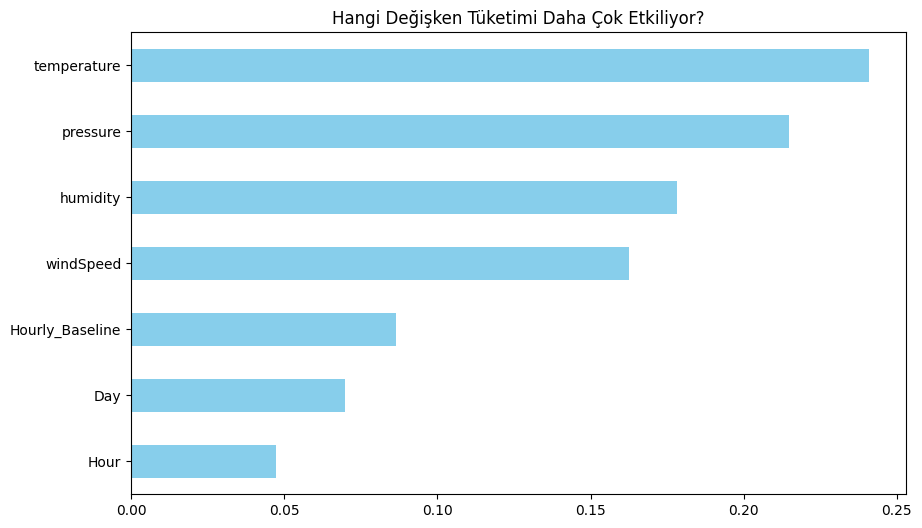

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. VERİ YÜKLEME
# DtypeWarning hatasını engellemek için low_memory=False kullanılır
try:
    df = pd.read_csv('Smart Home Dataset.csv', low_memory=False)
    print("Veri başarıyla yüklendi!")
except FileNotFoundError:
    print("Hata: 'Smart Home Dataset.csv' dosyası bulunamadı. Lütfen sol taraftaki dosya simgesinden yükleyin.")

# 2. VERİ TEMİZLEME VE ZAMAN İŞLEMLERİ
# Kaggle verisinde zaman 'time' sütunundadır ve string formatındadır.
df['time'] = pd.to_datetime(df['time'], unit='s') # Unix timestamp ise
df['Hour'] = df['time'].dt.hour
df['Day'] = df['time'].dt.dayofweek

# Gereksiz veya boş sütunları temizleyelim
df = df.dropna()

# Kaggle verisinde ana tüketim 'use [kW]' sütunundadır.
target_col = 'use [kW]'

# 3. PIVOT İŞLEMİ (Baseline Oluşturma)
# İstenilen: Her saatteki "normal" (ortalama) tüketimi hesapla
# Bu işlem modelin 'normal' alışkanlığı referans almasını sağlar.
pivot_table = df.pivot_table(values=target_col,
                             index=['Hour'],
                             aggfunc='mean').reset_index()

pivot_table.rename(columns={target_col: 'Hourly_Baseline'}, inplace=True)

# Pivot bilgisini ana tabloya 'Hour' üzerinden ekliyoruz
df = df.merge(pivot_table, on='Hour', how='left')

print("\nPivot işlemi tamamlandı. Baseline özelliği eklendi.")
print(df[['time', target_col, 'Hourly_Baseline']].head())

# 4. MODEL İÇİN ÖZELLİK SEÇİMİ
# Kaggle verisindeki hava durumu sütunlarını kullanıyoruz
features = ['Hour', 'Day', 'temperature', 'humidity', 'pressure', 'windSpeed', 'Hourly_Baseline']
X = df[features]
y = df[target_col]

# Eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. MODEL EĞİTİMİ (Random Forest)
print("\nModel eğitiliyor... (Bu işlem verinin boyutuna göre biraz sürebilir)")
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

# 6. SONUÇLAR VE GÖRSELLEŞTİRME
y_pred = rf_model.predict(X_test)

print("-" * 30)
print(f"Model R2 Skoru: {r2_score(y_test, y_pred):.4f}")
print(f"Hata Payı (MAE): {mean_absolute_error(y_test, y_pred):.4f} kW")
print("-" * 30)

# Özellik Önem Sıralaması
plt.figure(figsize=(10,6))
importances = pd.Series(rf_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Hangi Değişken Tüketimi Daha Çok Etkiliyor?')
plt.show()